In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from utils.matrix_builder import create_expanded_feature_matrix, create_feature_matrix

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load Database
csv_hour_file = '../data/ta_metrics/final_price_ta_metrics.csv'
df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])

def regression_training(df, sliding_window, lag_price_window, DEBUG):
    """
    Train a regression model using a sliding window approach.
    
    Parameters:
    - df: DataFrame containing the dataset with features and target variable.
    - sliding_window: Number of rows to use for training in each sliding window.
    - lag_price_window: Number of previous days to use as features.
    
    Returns:
    - prediction_df: DataFrame containing predictions and actual values.
    """
    if DEBUG:
        print("Debug mode is ON. Detailed output will be printed.")

    # Validate input parameters
    if sliding_window <= lag_price_window:
        raise ValueError("Sliding window must be greater than to the price feature window.")

    training_sliding_window = sliding_window + 1  # +1 to include the next row as the test set

    # Calculate number of sliding window models to train in the dataset
    num_sliding_windows = len(df) - training_sliding_window
    if DEBUG:
        # Training for sliding windows and price feature window
        print(f"Training sliding window size: {training_sliding_window}, Price feature window size: {lag_price_window}")
        print(f"Number of rows in the dataset: {len(df)}")

    print(f"Number of models to train: {num_sliding_windows}")

    # Initialize lists to store predictions, actuals, and timestamps
    predictions_list = []
    actuals_list = []
    timestamps_list = []

    model = LinearRegression()  # Using Linear Regression as a baseline model

    for i in range(num_sliding_windows):
        if DEBUG:
            print(f"Processing sliding window {i + 1}/{num_sliding_windows}...")

        # Ensure we do not exceed the DataFrame length
        if i + training_sliding_window >= len(df):
            break  # Avoid index out of bounds
        
        sliding_window_set = df.iloc[i : i + training_sliding_window]

        if DEBUG:
            print(f"Sliding window should have {training_sliding_window} rows, got {len(sliding_window_set)} rows.")
            print(f"Sliding window set:\n{sliding_window_set}")
        
        # Create feature matrix and target variable for training
        X_train, y_train = create_expanded_feature_matrix(sliding_window_set, lag_price_window)
        if DEBUG:
            print(f"Feature matrix shape: {X_train.shape}, Target variable shape: {y_train.shape}")
            print(f"Feature matrix:\n{X_train.head()}")
            print(f"Target variable:\n{y_train.head()}")

        # Split for training and prediction
        X_train_fit = X_train.iloc[:-1]
        y_train_fit = y_train.iloc[:-1]

        X_to_predict = X_train.iloc[-1:]
        y_to_predict = y_train.iloc[-1]

        if DEBUG:
            print(f"Training features shape: {X_train_fit.shape}, Training target shape: {y_train_fit.shape}")
            print(f"Features to predict shape: {X_to_predict.shape}, Target to predict: {y_to_predict}")

        # Scale features for better convergence
        scaler = StandardScaler()
        X_train_fit_scaled = scaler.fit_transform(X_train_fit)
        X_to_predict_scaled = scaler.transform(X_to_predict)

        model.fit(X_train_fit_scaled, y_train_fit)
        y_predicted = model.predict(X_to_predict_scaled)
        
        # Add a lower bounds to set extreme negative predictions to 0, assuming prices cannot be negative
        if y_predicted[0] < 0:
            y_predicted[0] = 0

        # Store results
        predictions_list.append(y_predicted[0])
        actuals_list.append(y_to_predict)
        if 'Datetime' in sliding_window_set.columns:
            timestamps_list.append(sliding_window_set.iloc[-1]['Datetime'])
        else:
            timestamps_list.append(i + training_sliding_window - 1)

    # Create final prediction DataFrame
    prediction_df = pd.DataFrame({
        'Timestamp': timestamps_list,
        'Predicted': predictions_list,
        'Actual': actuals_list
    })


    return prediction_df



def regression_training_gt(df, sliding_window, lag_price_window, DEBUG):
    """
    Train a regression model using a sliding window approach.
    
    Parameters:
    - df: DataFrame containing the dataset with features and target variable.
    - sliding_window: Number of rows to use for training in each sliding window.
    - lag_price_window: Number of previous days to use as features.
    
    Returns:
    - prediction_df: DataFrame containing predictions and actual values.
    """
    if DEBUG:
        print("Debug mode is ON. Detailed output will be printed.")

    # Validate input parameters
    if sliding_window <= lag_price_window:
        raise ValueError("Sliding window must be greater than to the price feature window.")

    training_sliding_window = sliding_window + 1  # +1 to include the next row as the test set

    # Calculate number of sliding window models to train in the dataset
    num_sliding_windows = len(df) - training_sliding_window
    if DEBUG:
        # Training for sliding windows and price feature window
        print(f"Training sliding window size: {training_sliding_window}, Price feature window size: {lag_price_window}")
        print(f"Number of rows in the dataset: {len(df)}")

    print(f"Number of models to train: {num_sliding_windows}")

    # Initialize lists to store predictions, actuals, and timestamps
    predictions_list = []
    actuals_list = []
    timestamps_list = []

    model = LinearRegression()  # Using Linear Regression as a baseline model

    for i in range(num_sliding_windows):
        if DEBUG:
            print(f"Processing sliding window {i + 1}/{num_sliding_windows}...")

        # Ensure we do not exceed the DataFrame length
        if i + training_sliding_window >= len(df):
            break  # Avoid index out of bounds
        
        sliding_window_set = df.iloc[i : i + training_sliding_window]

        if DEBUG:
            print(f"Sliding window should have {training_sliding_window} rows, got {len(sliding_window_set)} rows.")
            print(f"Sliding window set:\n{sliding_window_set}")
        
        # Create feature matrix and target variable for training
        X_train, y_train = create_feature_matrix(sliding_window_set, lag_price_window)
        if DEBUG:
            print(f"Feature matrix shape: {X_train.shape}, Target variable shape: {y_train.shape}")
            print(f"Feature matrix:\n{X_train.head()}")
            print(f"Target variable:\n{y_train.head()}")

        # Split for training and prediction
        X_train_fit = X_train.iloc[:-1]
        y_train_fit = y_train.iloc[:-1]

        X_to_predict = X_train.iloc[-1:]
        y_to_predict = y_train.iloc[-1]

        if DEBUG:
            print(f"Training features shape: {X_train_fit.shape}, Training target shape: {y_train_fit.shape}")
            print(f"Features to predict shape: {X_to_predict.shape}, Target to predict: {y_to_predict}")

        model.fit(X_train_fit, y_train_fit)
        y_predicted = model.predict(X_to_predict)
        
        # Add a lower bounds to set extreme negative predictions to 0, assuming prices cannot be negative
        if y_predicted[0] < 0:
            y_predicted[0] = 0

        # Store results
        predictions_list.append(y_predicted[0])
        actuals_list.append(y_to_predict)
        if 'Datetime' in sliding_window_set.columns:
            timestamps_list.append(sliding_window_set.iloc[-1]['Datetime'])
        else:
            timestamps_list.append(i + training_sliding_window - 1)

    # Create final prediction DataFrame
    prediction_df = pd.DataFrame({
        'Timestamp': timestamps_list,
        'Predicted': predictions_list,
        'Actual': actuals_list
    })


    return prediction_df

In [32]:
sliding_window = 10
lag_price_window = 3
DEBUG = False

prediction_df = regression_training(df, sliding_window, lag_price_window, DEBUG)

actuals_list = prediction_df['Actual'].values
predictions_list = prediction_df['Predicted'].values
timestamps_list = prediction_df['Timestamp'].values

mse = mean_squared_error(actuals_list, predictions_list)
mae = mean_absolute_error(actuals_list, predictions_list)
r2 = r2_score(actuals_list, predictions_list)

print(f"Overall metrics - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# Expectation Shortfall - Calculate metrics for worst predictions
prediction_errors = np.abs(predictions_list - actuals_list)
worst_percentiles = [25, 15, 5, 1]  # Worst X% of predictions

print("\nExpectation Shortfall - Metrics for worst predictions:")
for p in worst_percentiles:
	# Filter by worst predictions (highest errors)
	error_threshold = np.percentile(prediction_errors, 100 - p)
	worst_indices = prediction_errors >= error_threshold
	
	if np.sum(worst_indices) > 0:
		worst_actuals = actuals_list[worst_indices]
		worst_predictions = predictions_list[worst_indices]
		
		mse_worst = mean_squared_error(worst_actuals, worst_predictions)
		mae_worst = mean_absolute_error(worst_actuals, worst_predictions)
		avg_error = np.mean(prediction_errors[worst_indices])
		
		print(f"Worst {p}% predictions - Count: {len(worst_actuals)}, MSE: {mse_worst:.4f}, MAE: {mae_worst:.4f}, Avg Error: {avg_error:.4f}")

Number of models to train: 2249
Overall metrics - MSE: 800878.9551, MAE: 60.7754, R²: -233.7056

Expectation Shortfall - Metrics for worst predictions:
Worst 25% predictions - Count: 563, MSE: 3198690.7295, MAE: 212.1253, Avg Error: 212.1253
Worst 15% predictions - Count: 338, MSE: 5326612.4467, MAE: 323.2756, Avg Error: 323.2756
Worst 5% predictions - Count: 113, MSE: 15919857.6133, MAE: 809.7351, Avg Error: 809.7351
Worst 1% predictions - Count: 23, MSE: 78078587.2183, MAE: 3292.7310, Avg Error: 3292.7310


Prints parameters as it goes

In [33]:
# Debug parameter
DEBUG = False

# Define the Sliding Windows for the runs
sliding_windows = [7, 10, 15, 30, 90]  # of days to train on (matrix rows)
lag_price_windows = [1, 2, 4, 6]  # of previous days to use as features (matrix columns)
# lag_price_window must be less than sliding_window
percentiles = [99, 95, 85, 75]

for sliding_window in sliding_windows:
    for lag_price_window in lag_price_windows:
        print(f"\nRunning regression training with sliding window: {sliding_window}, price feature window: {lag_price_window}")

        # Run the regression training
        prediction_df = regression_training(df, sliding_window, lag_price_window, DEBUG)
        
        # Calculate overall metrics
        actuals_list = prediction_df['Actual'].values
        predictions_list = prediction_df['Predicted'].values
        timestamps_list = prediction_df['Timestamp'].values

        mse = mean_squared_error(actuals_list, predictions_list)
        mae = mean_absolute_error(actuals_list, predictions_list)
        r2 = r2_score(actuals_list, predictions_list)
        

        # Calculate prediction errors for filtering
        prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

        print("\nMetrics for best predictions by error percentiles:")
        print(f"Overall predictions (100%) - Count: {len(predictions_list)}, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

        for p in percentiles:
            # Filter by best predictions (lowest errors)
            error_threshold = np.percentile(prediction_errors, p)
            
            # Get indices of predictions with errors below threshold
            best_indices = prediction_errors <= error_threshold
            
            filtered_actuals = np.array(actuals_list)[best_indices]
            filtered_predictions = np.array(predictions_list)[best_indices]
            filtered_timestamps = np.array(timestamps_list)[best_indices]
            
            if len(filtered_actuals) > 0:
                mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
                mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
                r2_p = r2_score(filtered_actuals, filtered_predictions)
                
                # Save the filtered predictions and actuals in a DataFrame
                filtered_df = pd.DataFrame({
                    'Timestamp': filtered_timestamps,
                    'Actual': filtered_actuals,
                    'Predicted': filtered_predictions,
                    'Error': np.abs(filtered_predictions - filtered_actuals)
                })
                filtered_df.to_csv(f'best_predictions_percentile_{p}.csv', index=False)
                
                print(f"Best {p}% predictions - Data Points: {len(filtered_predictions)}/{len(predictions_list)}, MSE: {mse_p:.4f}, MAE: {mae_p:.4f}, R²: {r2_p:.4f}")
            else:
                print(f"Best {p}% predictions - No data available")


Running regression training with sliding window: 7, price feature window: 1
Number of models to train: 2252

Metrics for best predictions by error percentiles:
Overall predictions (100%) - Count: 2252, MSE: 259273.7408, MAE: 54.8755, R²: -75.0771
Best 99% predictions - Data Points: 2229/2252, MSE: 2698.6227, MAE: 27.8762, R²: 0.2083
Best 95% predictions - Data Points: 2139/2252, MSE: 1065.6178, MAE: 21.1339, R²: 0.6463
Best 85% predictions - Data Points: 1914/2252, MSE: 399.8702, MAE: 14.2046, R²: 0.8506
Best 75% predictions - Data Points: 1689/2252, MSE: 185.9917, MAE: 10.1871, R²: 0.9252

Running regression training with sliding window: 7, price feature window: 2
Number of models to train: 2252

Metrics for best predictions by error percentiles:
Overall predictions (100%) - Count: 2252, MSE: 722325.1150, MAE: 62.7840, R²: -210.9474
Best 99% predictions - Data Points: 2229/2252, MSE: 2449.3239, MAE: 26.6288, R²: 0.2818
Best 95% predictions - Data Points: 2139/2252, MSE: 955.1106, MAE

Ground truth

In [34]:
# Debug parameter
DEBUG = False

# Define the Sliding Windows for the runs
sliding_windows = [7, 10, 15, 30, 90]  # of days to train on (matrix rows)
lag_price_windows = [1, 2, 4, 6]  # of previous days to use as features (matrix columns)
# lag_price_window must be less than sliding_window
percentiles = [99, 95, 85, 75]

# Initialize comprehensive results list
comprehensive_results = []

for sliding_window in sliding_windows:
    for lag_price_window in lag_price_windows:
        print(f"\nRunning regression training with sliding window: {sliding_window}, price feature window: {lag_price_window}")

        # Run the regression training
        prediction_df = regression_training_gt(df, sliding_window, lag_price_window, DEBUG)
        
        # Calculate overall metrics
        actuals_list = prediction_df['Actual'].values
        predictions_list = prediction_df['Predicted'].values
        timestamps_list = prediction_df['Timestamp'].values

        mse = mean_squared_error(actuals_list, predictions_list)
        mae = mean_absolute_error(actuals_list, predictions_list)
        r2 = r2_score(actuals_list, predictions_list)
        
        # Calculate prediction errors for filtering
        prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

        # Add overall results (100% percentile)
        comprehensive_results.append({
            'sliding_window': sliding_window,
            'lag_price_window': lag_price_window,
            'percentile': 100,
            'data_points': len(predictions_list),
            # 'total_predictions': len(predictions_list),
            # 'data_points_percentage': 100.0,
            'mse': mse,
            'mae': mae,
            'r2': r2
        })

        for p in percentiles:
            # Filter by best predictions (lowest errors)
            error_threshold = np.percentile(prediction_errors, p)
            
            # Get indices of predictions with errors below threshold
            best_indices = prediction_errors <= error_threshold
            
            filtered_actuals = np.array(actuals_list)[best_indices]
            filtered_predictions = np.array(predictions_list)[best_indices]
            
            if len(filtered_actuals) > 0:
                mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
                mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
                r2_p = r2_score(filtered_actuals, filtered_predictions)
                
                # Add to comprehensive results
                comprehensive_results.append({
                    'sliding_window': sliding_window,
                    'lag_price_window': lag_price_window,
                    'percentile': p,
                    'data_points': len(filtered_predictions),
                    # 'total_predictions': len(predictions_list),
                    # 'data_points_percentage': round((len(filtered_predictions) / len(predictions_list)) * 100, 2),
                    'mse': mse_p,
                    'mae': mae_p,
                    'r2': r2_p
                })
            else:
                # Add entry for no data available
                comprehensive_results.append({
                    'sliding_window': sliding_window,
                    'lag_price_window': lag_price_window,
                    'percentile': p,
                    'data_points': 0,
                    # 'total_predictions': len(predictions_list),
                    # 'data_points_percentage': 0.0,
                    'mse': np.nan,
                    'mae': np.nan,
                    'r2': np.nan
                })

# Create comprehensive DataFrame
comprehensive_gt_df = pd.DataFrame(comprehensive_results)

# Save to CSV
comprehensive_gt_df.to_csv('comprehensive_regression_gt_results.csv', index=False)
print(f"\nResults saved to 'comprehensive_regression_gt_results.csv'")


Running regression training with sliding window: 7, price feature window: 1
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 2
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 4
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 6
Number of models to train: 2252

Running regression training with sliding window: 10, price feature window: 1
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 2
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 4
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 6
Number of models to train: 2249

Running regression training with sliding window: 15, price feature window: 1
Number of models to train: 2244

Running regre

In [35]:
# Display the comprehensive results
print("\n" + "="*80)
print("COMPREHENSIVE REGRESSION RESULTS")
print("="*80)
print(comprehensive_gt_df.to_string(index=False))

# Display summary statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)
print(f"Total experiments: {len(comprehensive_gt_df)}")
print(f"Sliding windows tested: {sorted(comprehensive_gt_df['sliding_window'].unique())}")
print(f"Price feature windows tested: {sorted(comprehensive_gt_df['lag_price_window'].unique())}")
print(f"Percentiles analyzed: {sorted(comprehensive_gt_df['percentile'].unique())}")

# Show best performing configurations
print("\n" + "="*50)
print("TOP 10 BEST R² SCORES")
print("="*50)
best_r2 = comprehensive_gt_df.nlargest(10, 'r2')[['sliding_window', 'lag_price_window', 'percentile', 'r2', 'mse', 'mae']]
print(best_r2.to_string(index=False))


COMPREHENSIVE REGRESSION RESULTS
 sliding_window  lag_price_window  percentile  data_points          mse       mae        r2
              7                 1         100         2252  1000.954439 19.220109  0.706296
              7                 1          99         2229   775.961102 17.904767  0.766035
              7                 1          95         2139   465.932182 14.908348  0.845200
              7                 1          85         1914   207.552180 10.685039  0.921539
              7                 1          75         1689   107.621086  8.013336  0.951409
              7                 2         100         2252  3952.225158 27.679127 -0.159677
              7                 2          99         2229  1480.667507 23.742913  0.557800
              7                 2          95         2139   809.645306 19.322617  0.736289
              7                 2          85         1914   346.424043 13.629689  0.872505
              7                 2          75 

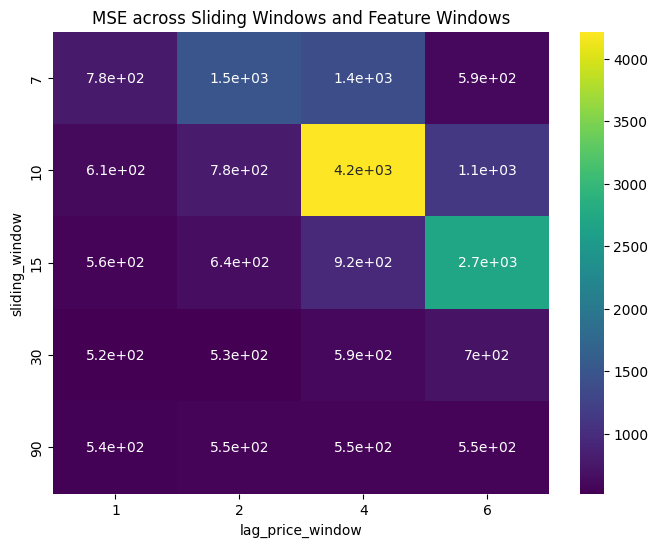

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

df_overall = comprehensive_gt_df[
    (comprehensive_gt_df['percentile'] == 99)
]

pivot = df_overall.pivot_table(
    values='mse',
    index='sliding_window',
    columns='lag_price_window'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='viridis')
plt.title('MSE across Sliding Windows and Feature Windows')
plt.show()

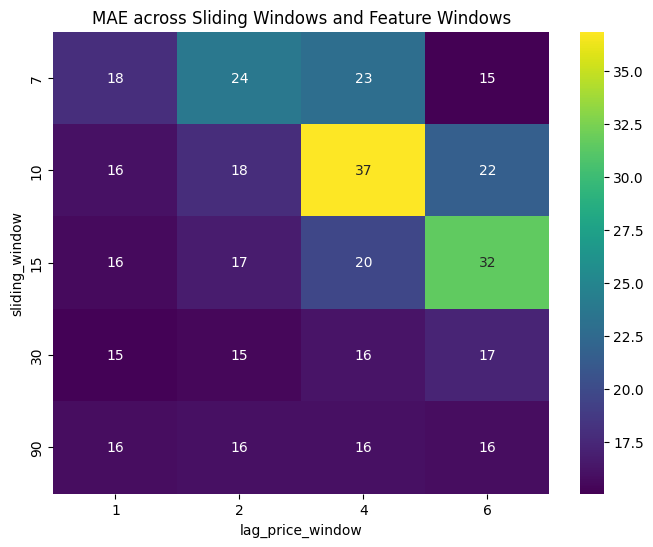

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

df_overall = comprehensive_gt_df[
    (comprehensive_gt_df['percentile'] == 99)
]

pivot = df_overall.pivot_table(
    values='mae',
    index='sliding_window',
    columns='lag_price_window'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='viridis')
plt.title('MAE across Sliding Windows and Feature Windows')
plt.show()


In [ ]:
import plotly.express as px

df_overall = comprehensive_gt_df[
    (comprehensive_gt_df['percentile'] == 100) & 
    (comprehensive_gt_df['analysis_type'] == 'overall')
]

fig = px.scatter(df_overall, 
                 x='mse', y='worst_avg_error', 
                 size='data_points', color='sliding_window',
                 hover_data=['price_feature_window'])
fig.show()

In [39]:
best_configs = df_overall.sort_values(by='mse').head(10)
print(best_configs)

    sliding_window  lag_price_window  percentile  data_points         mse  \
61              30                 1          99         2206  519.777167   
66              30                 2          99         2206  530.800172   
81              90                 1          99         2147  544.762200   
86              90                 2          99         2147  551.626241   
91              90                 4          99         2147  554.031603   
96              90                 6          99         2147  554.765456   
41              15                 1          99         2221  562.821588   
71              30                 4          99         2206  592.277312   
16               7                 6          99         2229  592.975588   
21              10                 1          99         2226  614.071813   

          mae        r2  
61  15.195883  0.842020  
66  15.472885  0.841583  
81  15.817626  0.838825  
86  15.934068  0.837596  
91  15.977113  0.83623

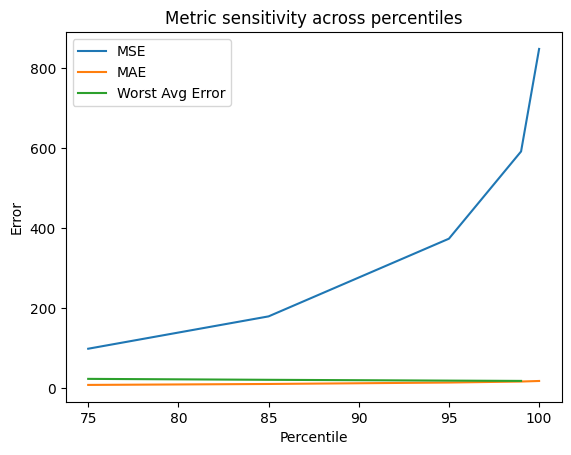

In [ ]:
import matplotlib.pyplot as plt

subset = comprehensive_gt_df[
    (comprehensive_gt_df['sliding_window'] == 30) & 
    (comprehensive_gt_df['lag_price_window'] == 4)
]

plt.plot(subset['percentile'], subset['mse'], label='MSE')
plt.plot(subset['percentile'], subset['mae'], label='MAE')
plt.plot(subset['percentile'], subset['worst_avg_error'], label='Worst Avg Error')
plt.xlabel('Percentile')
plt.ylabel('Error')
plt.legend()
plt.title('Metric sensitivity across percentiles')
plt.show()

In [ ]:
# # Show best performing configurations
# print("\n" + "="*50)
# print("TOP 10 BEST R² SCORES")
# print("="*50)
# best_r2 = comprehensive_gt_df.nlargest(10, 'r2')[['sliding_window', 'lag_price_window', 'percentile', 'r2', 'mse', 'mae']]
# print(best_r2.to_string(index=False))

# Analyze performance by sliding window and price feature window combinations
print("\n" + "="*70)
print("PERFORMANCE ANALYSIS BY WINDOW COMBINATIONS")
print("="*70)

# Group by sliding_window and lag_price_window to get average performance
window_performance = comprehensive_gt_df.groupby(['sliding_window', 'lag_price_window']).agg({
    'r2': ['mean', 'std', 'max'],
    'mse': ['mean', 'std', 'min'],
    'mae': ['mean', 'std', 'min'],
    'data_points': 'mean'
}).round(4)

# Flatten column names
window_performance.columns = ['_'.join(col).strip() for col in window_performance.columns.values]
window_performance = window_performance.reset_index()

# Sort by average R² (descending)
window_performance_r2 = window_performance.sort_values('r2_mean', ascending=False)
print("\nBest Window Combinations by Average R² Score:")
print(window_performance_r2.to_string(index=False))

# Sort by average MSE (ascending - lower is better)
window_performance_mse = window_performance.sort_values('mse_mean', ascending=True)
print("\n" + "="*70)
print("Best Window Combinations by Average MSE (Lower is Better):")
print(window_performance_mse.to_string(index=False))

# Create a summary ranking system
print("\n" + "="*70)
print("COMPREHENSIVE RANKING ANALYSIS")
print("="*70)

# Rank each combination on different metrics
ranking_df = window_performance.copy()
ranking_df['r2_rank'] = ranking_df['r2_mean'].rank(ascending=False)
ranking_df['mse_rank'] = ranking_df['mse_mean'].rank(ascending=True)  # Lower MSE is better
ranking_df['mae_rank'] = ranking_df['mae_mean'].rank(ascending=True)  # Lower MAE is better

# Calculate composite ranking (lower is better)
ranking_df['composite_rank'] = (ranking_df['r2_rank'] + ranking_df['mse_rank'] + ranking_df['mae_rank']) / 3
ranking_df = ranking_df.sort_values('composite_rank')

print("Window Combinations Ranked by Composite Score (R², MSE, MAE):")
display_cols = ['sliding_window', 'lag_price_window', 'r2_mean', 'mse_mean', 'mae_mean', 
                'r2_rank', 'mse_rank', 'mae_rank', 'composite_rank']
print(ranking_df[display_cols].to_string(index=False))

# Analyze by individual sliding windows
print("\n" + "="*70)
print("PERFORMANCE BY SLIDING WINDOW SIZE")
print("="*70)

sliding_window_perf = comprehensive_gt_df.groupby('sliding_window').agg({
    'r2': ['mean', 'std', 'max', 'min'],
    'mse': ['mean', 'std', 'min', 'max'],
    'mae': ['mean', 'std', 'min', 'max']
}).round(4)

sliding_window_perf.columns = ['_'.join(col).strip() for col in sliding_window_perf.columns.values]
sliding_window_perf = sliding_window_perf.reset_index().sort_values('r2_mean', ascending=False)
print(sliding_window_perf.to_string(index=False))

# Analyze by individual price feature windows
print("\n" + "="*70)
print("PERFORMANCE BY PRICE FEATURE WINDOW SIZE")
print("="*70)

price_feature_perf = comprehensive_gt_df.groupby('lag_price_window').agg({
    'r2': ['mean', 'std', 'max', 'min'],
    'mse': ['mean', 'std', 'min', 'max'],
    'mae': ['mean', 'std', 'min', 'max']
}).round(4)

price_feature_perf.columns = ['_'.join(col).strip() for col in price_feature_perf.columns.values]
price_feature_perf = price_feature_perf.reset_index().sort_values('r2_mean', ascending=False)
print(price_feature_perf.to_string(index=False))

# Create detailed percentile analysis for top combinations
print("\n" + "="*70)
print("DETAILED ANALYSIS OF TOP 3 WINDOW COMBINATIONS")
print("="*70)

top_10_combinations = ranking_df.head(10)
for idx, row in top_10_combinations.iterrows():
    sw = int(row['sliding_window'])
    pfw = int(row['lag_price_window'])
    
    print(f"\nSliding Window: {sw}, Price Feature Window: {pfw}")
    print("-" * 50)
    
    # Filter data for this combination
    combo_data = comprehensive_gt_df[
        (comprehensive_gt_df['sliding_window'] == sw) & 
        (comprehensive_gt_df['lag_price_window'] == pfw)
    ].sort_values('percentile', ascending=False)
    
    display_cols = ['percentile', 'data_points', 'r2', 'mse', 'mae']
    print(combo_data[display_cols].to_string(index=False))

# Check if comprehensive_gt_df exists and has the required columns
try:
    if 'comprehensive_gt_df' not in globals():
        print("Error: comprehensive_gt_df not found. Please run the grid search analysis first.")
    else:
        print(f"comprehensive_gt_df columns: {list(comprehensive_gt_df.columns)}")
        print(f"comprehensive_gt_df shape: {comprehensive_gt_df.shape}")
        
        # Check if required columns exist
        required_cols = ['sliding_window', 'lag_price_window', 'percentile', 'r2', 'mse', 'mae', 'data_points']
        missing_cols = [col for col in required_cols if col not in comprehensive_gt_df.columns]
        
        if missing_cols:
            print(f"Missing columns: {missing_cols}")
            print("Available columns:", list(comprehensive_gt_df.columns))
        else:
            # Save detailed analysis to CSV only if all columns exist
            window_performance_r2.to_csv('window_combinations_analysis.csv', index=False)
            ranking_df[display_cols].to_csv('window_combinations_ranking.csv', index=False)
            print(f"\nDetailed analysis saved to 'window_combinations_analysis.csv' and 'window_combinations_ranking.csv'")
            
except Exception as e:
    print(f"Error in final save operation: {e}")
    print("Attempting to save available data...")
    
    # Save what we can
    if 'window_performance_r2' in locals():
        window_performance_r2.to_csv('window_combinations_analysis.csv', index=False)
        print("Saved window_combinations_analysis.csv")
    
    if 'ranking_df' in locals():
        # Use available columns for ranking
        available_display_cols = [col for col in ['sliding_window', 'lag_price_window', 'r2_mean', 'mse_mean', 'mae_mean', 'composite_rank'] if col in ranking_df.columns]
        ranking_df[available_display_cols].to_csv('window_combinations_ranking.csv', index=False)
        print("Saved window_combinations_ranking.csv with available columns")


PERFORMANCE ANALYSIS BY WINDOW COMBINATIONS

Best Window Combinations by Average R² Score:
 sliding_window  price_feature_window  r2_mean  r2_std  r2_max  mse_mean   mse_std  mse_min  mae_mean  mae_std  mae_min  data_points_mean
             30                     1   0.8848  0.0662  0.9609  358.4979  249.1668  86.9531   12.2294   3.8393   7.2043            2023.6
             90                     1   0.8824  0.0657  0.9591  377.1903  253.7318  97.4688   12.8134   3.8685   7.7254            1969.2
             90                     6   0.8815  0.0695  0.9622  383.6547  265.5084  93.3325   12.7177   3.9504   7.5212            1969.2
             90                     2   0.8808  0.0662  0.9590  383.7849  256.6580  98.9979   12.9152   3.9097   7.7560            1969.2
             30                     2   0.8808  0.0694  0.9581  375.0190  262.4479  91.6231   12.5207   3.8904   7.4095            2023.6
             90                     4   0.8797  0.0674  0.9589  386.7593  260.44

Saves parameters to CSV

In [ ]:
# Debug parameter
DEBUG = False

# Define the Sliding Windows for the runs
sliding_windows = [7, 10, 15, 30, 90]  # of days to train on (matrix rows)
lag_price_windows = [1, 2, 4, 6]  # of previous days to use as features (matrix columns)
# lag_price_window must be less than sliding_window
percentiles = [99, 95, 85, 75]

# Initialize comprehensive results list
comprehensive_results = []

for sliding_window in sliding_windows:
    for lag_price_window in lag_price_windows:
        print(f"\nRunning regression training with sliding window: {sliding_window}, price feature window: {lag_price_window}")

        # Run the regression training
        prediction_df = regression_training(df, sliding_window, lag_price_window, DEBUG)
        
        # Calculate overall metrics
        actuals_list = prediction_df['Actual'].values
        predictions_list = prediction_df['Predicted'].values
        timestamps_list = prediction_df['Timestamp'].values

        mse = mean_squared_error(actuals_list, predictions_list)
        mae = mean_absolute_error(actuals_list, predictions_list)
        r2 = r2_score(actuals_list, predictions_list)
        
        # Calculate prediction errors for filtering
        prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

        # Add overall results (100% percentile)
        comprehensive_results.append({
            'sliding_window': sliding_window,
            'lag_price_window': lag_price_window,
            'percentile': 100,
            'data_points': len(predictions_list),
            # 'total_predictions': len(predictions_list),
            # 'data_points_percentage': 100.0,
            'mse': mse,
            'mae': mae,
            'r2': r2
        })

        for p in percentiles:
            # Filter by best predictions (lowest errors)
            error_threshold = np.percentile(prediction_errors, p)
            
            # Get indices of predictions with errors below threshold
            best_indices = prediction_errors <= error_threshold
            
            filtered_actuals = np.array(actuals_list)[best_indices]
            filtered_predictions = np.array(predictions_list)[best_indices]
            
            if len(filtered_actuals) > 0:
                mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
                mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
                r2_p = r2_score(filtered_actuals, filtered_predictions)
                
                # Add to comprehensive results
                comprehensive_results.append({
                    'sliding_window': sliding_window,
                    'lag_price_window': lag_price_window,
                    'percentile': p,
                    'data_points': len(filtered_predictions),
                    # 'total_predictions': len(predictions_list),
                    # 'data_points_percentage': round((len(filtered_predictions) / len(predictions_list)) * 100, 2),
                    'mse': mse_p,
                    'mae': mae_p,
                    'r2': r2_p
                })
            else:
                # Add entry for no data available
                comprehensive_results.append({
                    'sliding_window': sliding_window,
                    'lag_price_window': lag_price_window,
                    'percentile': p,
                    'data_points': 0,
                    # 'total_predictions': len(predictions_list),
                    # 'data_points_percentage': 0.0,
                    'mse': np.nan,
                    'mae': np.nan,
                    'r2': np.nan
                })

# Create comprehensive DataFrame
comprehensive_fe_df = pd.DataFrame(comprehensive_results)

# Save to CSV
comprehensive_fe_df.to_csv('comprehensive_regression_fe_results.csv', index=False)
print(f"\nResults saved to 'comprehensive_regression_fe_results.csv'")


Running regression training with sliding window: 7, price feature window: 1
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 2
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 4
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 6
Number of models to train: 2252

Running regression training with sliding window: 10, price feature window: 1
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 2
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 4
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 6
Number of models to train: 2249

Running regression training with sliding window: 15, price feature window: 1
Number of models to train: 2244

Running regre

In [ ]:
# Display the comprehensive results
print("\n" + "="*80)
print("COMPREHENSIVE REGRESSION RESULTS")
print("="*80)
print(comprehensive_fe_df.to_string(index=False))

# Display summary statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)
print(f"Total experiments: {len(comprehensive_fe_df)}")
print(f"Sliding windows tested: {sorted(comprehensive_fe_df['sliding_window'].unique())}")
print(f"Price feature windows tested: {sorted(comprehensive_fe_df['lag_price_window'].unique())}")
print(f"Percentiles analyzed: {sorted(comprehensive_fe_df['percentile'].unique())}")

# Show best performing configurations
print("\n" + "="*50)
print("TOP 10 BEST R² SCORES")
print("="*50)
best_r2 = comprehensive_fe_df.nlargest(10, 'r2')[['sliding_window', 'lag_price_window', 'percentile', 'r2', 'mse', 'mae']]
print(best_r2.to_string(index=False))


COMPREHENSIVE REGRESSION RESULTS
 sliding_window  price_feature_window  percentile  data_points          mse        mae          r2
              7                     1         100         2252 2.592737e+05  54.875469  -75.077084
              7                     1          99         2229 2.698623e+03  27.876181    0.208308
              7                     1          95         2139 1.065618e+03  21.133944    0.646304
              7                     1          85         1914 3.998702e+02  14.204561    0.850611
              7                     1          75         1689 1.859917e+02  10.187138    0.925227
              7                     2         100         2252 7.223251e+05  62.784019 -210.947374
              7                     2          99         2229 2.449324e+03  26.628760    0.281776
              7                     2          95         2139 9.551106e+02  20.109986    0.692653
              7                     2          85         1914 3.648154e+02

In [ ]:
# Debug parameter
DEBUG = False

# Define the Sliding Windows for the runs
sliding_windows = [7, 10, 15, 30, 90]  # of days to train on (matrix rows)
lag_price_windows = [1, 2, 4, 6]  # of previous days to use as features (matrix columns)
# lag_price_window must be less than sliding_window
percentiles = [99, 95, 85, 75]
# Expectation Shortfall - worst predictions percentiles
worst_percentiles = [25, 15, 5, 1]  # Worst X% of predictions

# Initialize comprehensive results list
comprehensive_results = []

for sliding_window in sliding_windows:
    for lag_price_window in lag_price_windows:
        print(f"\nRunning regression training with sliding window: {sliding_window}, price feature window: {lag_price_window}")

        # Run the regression training
        prediction_df = regression_training_gt(df, sliding_window, lag_price_window, DEBUG)
        
        # Calculate overall metrics
        actuals_list = prediction_df['Actual'].values
        predictions_list = prediction_df['Predicted'].values
        timestamps_list = prediction_df['Timestamp'].values

        mse = mean_squared_error(actuals_list, predictions_list)
        mae = mean_absolute_error(actuals_list, predictions_list)
        r2 = r2_score(actuals_list, predictions_list)
        
        # Expectation Shortfall - Calculate metrics for top X worst predictions

        # Calculate prediction errors for filtering
        prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

        # Add overall results (100% percentile)
        comprehensive_results.append({
            'sliding_window': sliding_window,
            'lag_price_window': lag_price_window,
            'percentile': 100,
            'analysis_type': 'overall',
            'data_points': len(predictions_list),
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'avg_error': np.mean(prediction_errors)
        })

        # Best predictions analysis (existing code)
        for p in percentiles:
            # Filter by best predictions (lowest errors)
            best_error_threshold = np.percentile(prediction_errors, p)
            
            # Expectation Shortfall - worst predictions analysis
            # Filter by best predictions (highest errors)
            worst_error_threshold = np.percentile(prediction_errors, 100 - p)

            # Get indices of predictions with errors below threshold
            best_indices = prediction_errors <= best_error_threshold

            worst_indices = prediction_errors >= worst_error_threshold

            filtered_actuals = np.array(actuals_list)[best_indices]
            filtered_predictions = np.array(predictions_list)[best_indices]

            filtered_es_actuals = np.array(actuals_list)[worst_indices]
            filtered_es_predictions = np.array(predictions_list)[worst_indices]
            
            if len(filtered_actuals) > 0:
                mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
                mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
                r2_p = r2_score(filtered_actuals, filtered_predictions)
                avg_error_wp = np.mean(prediction_errors[worst_indices])

                comprehensive_results.append({
                    'sliding_window': sliding_window,
                    'lag_price_window': lag_price_window,
                    'percentile': p,
                    'analysis_type': 'best',
                    'data_points': len(filtered_predictions),
                    'mse': mse_p,
                    'mae': mae_p,
                    'r2': r2_p,
                    'worst_avg_error': avg_error_wp
                })
            else:
                comprehensive_results.append({
                    'sliding_window': sliding_window,
                    'lag_price_window': lag_price_window,
                    'percentile': p,
                    'analysis_type': 'best',
                    'data_points': 0,
                    'mse': np.nan,
                    'mae': np.nan,
                    'r2': np.nan,
                    'worst_avg_error': np.nan
                })

# Create comprehensive DataFrame
comprehensive_gt_df = pd.DataFrame(comprehensive_results)

# Save to CSV
comprehensive_gt_df.to_csv('regression_gt_results.csv', index=False)
print(f"\nResults saved to 'regression_gt_results.csv'")



Running regression training with sliding window: 7, price feature window: 1
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 2
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 4
Number of models to train: 2252

Running regression training with sliding window: 7, price feature window: 6
Number of models to train: 2252

Running regression training with sliding window: 10, price feature window: 1
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 2
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 4
Number of models to train: 2249

Running regression training with sliding window: 10, price feature window: 6
Number of models to train: 2249

Running regression training with sliding window: 15, price feature window: 1
Number of models to train: 2244

Running regre

In [ ]:
# Display comprehensive analysis
print("\n" + "="*80)
print("COMPREHENSIVE REGRESSION RESULTS WITH EXPECTATION SHORTFALL")
print("="*80)

# Overall summary
print(f"Total experiments: {len(comprehensive_gt_df)}")
print(f"Analysis types: {sorted(comprehensive_gt_df['analysis_type'].unique())}")

# Best predictions summary
best_df = comprehensive_gt_df[comprehensive_gt_df['analysis_type'] == 'best']
if not best_df.empty:
    print("\n" + "="*50)
    print("TOP 10 BEST PREDICTIONS (by R²)")
    print("="*50)
    best_top = best_df.nlargest(10, 'r2')[['sliding_window', 'lag_price_window', 'percentile', 'r2', 'mse', 'mae', 'data_points']]
    print(best_top.to_string(index=False))

# Worst predictions summary (Expectation Shortfall)
worst_df = comprehensive_gt_df[comprehensive_gt_df['analysis_type'] == 'worst']
if not worst_df.empty:
    print("\n" + "="*50)
    print("EXPECTATION SHORTFALL - WORST PREDICTIONS ANALYSIS")
    print("="*50)
    worst_summary = worst_df.groupby(['sliding_window', 'lag_price_window']).agg({
        'mse': 'mean',
        'mae': 'mean',
        'r2': 'mean',
        'avg_error': 'mean',
        'data_points': 'mean'
    }).round(4).sort_values('mse', ascending=False)
    
    print("Window combinations ranked by worst-case MSE:")
    print(worst_summary.head(10).to_string())
    
    print(f"\nOverall Expectation Shortfall Statistics:")
    print(f"Average MSE for worst predictions: {worst_df['mse'].mean():.4f}")
    print(f"Average MAE for worst predictions: {worst_df['mae'].mean():.4f}")
    print(f"Average R² for worst predictions: {worst_df['r2'].mean():.4f}")
    print(f"Average Error for worst predictions: {worst_df['avg_error'].mean():.4f}")

# Risk analysis: Compare best vs worst for each configuration
print("\n" + "="*70)
print("RISK ANALYSIS - BEST VS WORST PERFORMANCE BY CONFIGURATION")
print("="*70)

risk_analysis = []
for sw in sliding_windows:
    for pfw in lag_price_windows:
        # Get best performance (75th percentile)
        best_75 = comprehensive_gt_df[
            (comprehensive_gt_df['sliding_window'] == sw) & 
            (comprehensive_gt_df['lag_price_window'] == pfw) & 
            (comprehensive_gt_df['analysis_type'] == 'best') &
            (comprehensive_gt_df['percentile'] == 75)
        ]
        
        # Get worst performance (25th percentile)
        worst_25 = comprehensive_gt_df[
            (comprehensive_gt_df['sliding_window'] == sw) & 
            (comprehensive_gt_df['lag_price_window'] == pfw) & 
            (comprehensive_gt_df['analysis_type'] == 'worst') &
            (comprehensive_gt_df['percentile'] == 25)
        ]
        
        if not best_75.empty and not worst_25.empty:
            best_r2 = best_75.iloc[0]['r2']
            worst_r2 = worst_25.iloc[0]['r2']
            best_mse = best_75.iloc[0]['mse']
            worst_mse = worst_25.iloc[0]['mse']
            
            risk_analysis.append({
                'sliding_window': sw,
                'lag_price_window': pfw,
                'best_r2': best_r2,
                'worst_r2': worst_r2,
                'r2_spread': best_r2 - worst_r2,
                'best_mse': best_mse,
                'worst_mse': worst_mse,
                'mse_ratio': worst_mse / best_mse if best_mse > 0 else np.nan
            })

risk_df = pd.DataFrame(risk_analysis)
if not risk_df.empty:
    # Sort by lowest risk (smallest spread and ratio)
    risk_df['risk_score'] = risk_df['mse_ratio'] - risk_df['r2_spread']  # Lower is better
    risk_df = risk_df.sort_values('risk_score')
    
    print("Window combinations ranked by risk (lower risk score is better):")
    display_cols = ['sliding_window', 'lag_price_window', 'best_r2', 'worst_r2', 'r2_spread', 'mse_ratio', 'risk_score']
    print(risk_df[display_cols].round(4).to_string(index=False))

# Save additional analysis files
if not best_df.empty:
    best_df.to_csv('best_predictions_analysis.csv', index=False)
if not worst_df.empty:
    worst_df.to_csv('expectation_shortfall_analysis.csv', index=False)
if not risk_df.empty:
    risk_df.to_csv('risk_analysis.csv', index=False)

print(f"\nAdditional analysis files saved:")
print(f"- best_predictions_analysis.csv")
print(f"- expectation_shortfall_analysis.csv") 
print(f"- risk_analysis.csv")


COMPREHENSIVE REGRESSION RESULTS WITH EXPECTATION SHORTFALL
Total experiments: 180
Analysis types: ['best', 'overall', 'worst']

TOP 10 BEST PREDICTIONS (by R²)
 sliding_window  price_feature_window  percentile       r2       mse      mae  data_points
              7                     6          75 0.973245 65.144557 6.139911         1689
             10                     1          75 0.962865 84.547861 7.131331         1687
             90                     6          75 0.962245 93.332462 7.521156         1627
             30                     1          75 0.960907 86.953149 7.204318         1672
             15                     1          75 0.960614 85.112917 7.177161         1683
             90                     1          75 0.959113 97.468763 7.725404         1627
             90                     2          75 0.959004 98.997887 7.755954         1627
             90                     4          75 0.958942 99.350174 7.790762         1627
             30    

In [ ]:
def calculate_expectation_shortfall(actuals, predictions, confidence_levels=[0.95, 0.99]):
    """
    Calculate true Expectation Shortfall (Expected Shortfall/CVaR)
    
    Parameters:
    - actuals: actual values
    - predictions: predicted values  
    - confidence_levels: list of confidence levels (e.g., [0.95, 0.99])
    
    Returns:
    - Dictionary with ES values for each confidence level
    """
    # Calculate prediction errors (losses)
    prediction_errors = np.abs(np.array(predictions) - np.array(actuals))
    
    results = {}
    
    for alpha in confidence_levels:
        # Calculate VaR (Value at Risk) - the alpha-quantile of losses
        var_threshold = np.percentile(prediction_errors, alpha * 100)
        
        # Calculate ES - expected value of losses beyond VaR
        tail_losses = prediction_errors[prediction_errors >= var_threshold]
        
        if len(tail_losses) > 0:
            expectation_shortfall = np.mean(tail_losses)
            results[f'ES_{int(alpha*100)}'] = expectation_shortfall
            results[f'VaR_{int(alpha*100)}'] = var_threshold
            results[f'ES_count_{int(alpha*100)}'] = len(tail_losses)
        else:
            results[f'ES_{int(alpha*100)}'] = np.nan
            results[f'VaR_{int(alpha*100)}'] = var_threshold
            results[f'ES_count_{int(alpha*100)}'] = 0
    
    return results

# Example usage in your loop:
for sliding_window in sliding_windows:
    for lag_price_window in lag_price_windows:
        # ...existing code...
        
        # Calculate true Expectation Shortfall
        es_results = calculate_expectation_shortfall(actuals_list, predictions_list, [0.95, 0.99])
        
        # Add ES results to comprehensive_results
        comprehensive_results.append({
            'sliding_window': sliding_window,
            'lag_price_window': lag_price_window,
            'analysis_type': 'expectation_shortfall',
            'mse': mse,
            'mae': mae,
            'r2': r2,
            **es_results  # Add all ES metrics
        })

In [ ]:
# I want to filter the results to the following percentiles and calculate the MSE, MAE, and R^2 for each percentile
# I also want to save the predictions and actuals for each percentile in a separate DataFrame

# Calculate prediction errors for filtering
prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

percentiles = [99, 95, 85, 75]
print("\nMetrics for best predictions by error percentiles:")

for p in percentiles:
    # Filter by best predictions (lowest errors)
    error_threshold = np.percentile(prediction_errors, p)
    
    # Get indices of predictions with errors below threshold
    best_indices = prediction_errors <= error_threshold
    
    filtered_actuals = np.array(actuals_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    filtered_timestamps = np.array(timestamps_list)[best_indices]
    
    if len(filtered_actuals) > 0:
        mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
        mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
        r2_p = r2_score(filtered_actuals, filtered_predictions)
        
        # Save the filtered predictions and actuals in a DataFrame
        filtered_df = pd.DataFrame({
            'Timestamp': filtered_timestamps,
            'Actual': filtered_actuals,
            'Predicted': filtered_predictions,
            'Error': np.abs(filtered_predictions - filtered_actuals)
        })
        filtered_df.to_csv(f'best_predictions_percentile_{p}.csv', index=False)
        
        print(f"Best {p}% predictions - Count: {len(filtered_actuals)}, MSE: {mse_p:.4f}, MAE: {mae_p:.4f}, R²: {r2_p:.4f}")
    else:
        print(f"Best {p}% predictions - No data available")



Metrics for best predictions by error percentiles:
Best 99% predictions - Count: 2226, MSE: 2412.0683, MAE: 27.3814, R²: 0.2949
Best 95% predictions - Count: 2136, MSE: 1045.3464, MAE: 21.1534, R²: 0.6645
Best 85% predictions - Count: 1911, MSE: 409.0859, MAE: 14.3468, R²: 0.8539
Best 75% predictions - Count: 1687, MSE: 186.7811, MAE: 10.2502, R²: 0.9282


In [ ]:
# I want to create a comprehensive table displaying the metrics for each percentile
percentile_metrics = []
for p in percentiles:
    error_threshold = np.percentile(prediction_errors, p)
    best_indices = prediction_errors <= error_threshold
    
    filtered_actuals = np.array(actuals_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    
    if len(filtered_actuals) > 0:
        mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
        mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
        r2_p = r2_score(filtered_actuals, filtered_predictions)
        
        percentile_metrics.append({
            'Percentile': p,
            'Datapoint Count': len(filtered_actuals),
            'MSE': mse_p,
            'MAE': mae_p,
            'R²': r2_p
        })

# print the comprehensive table
percentile_metrics_df = pd.DataFrame(percentile_metrics)
print("\nComprehensive Metrics by Percentile:")
print(percentile_metrics_df)


Comprehensive Metrics by Percentile:
   Percentile  Data pointCount          MSE        MAE        R²
0          99             2226  2412.068324  27.381404  0.294932
1          95             2136  1045.346350  21.153444  0.664534
2          85             1911   409.085876  14.346771  0.853860
3          75             1687   186.781100  10.250199  0.928213


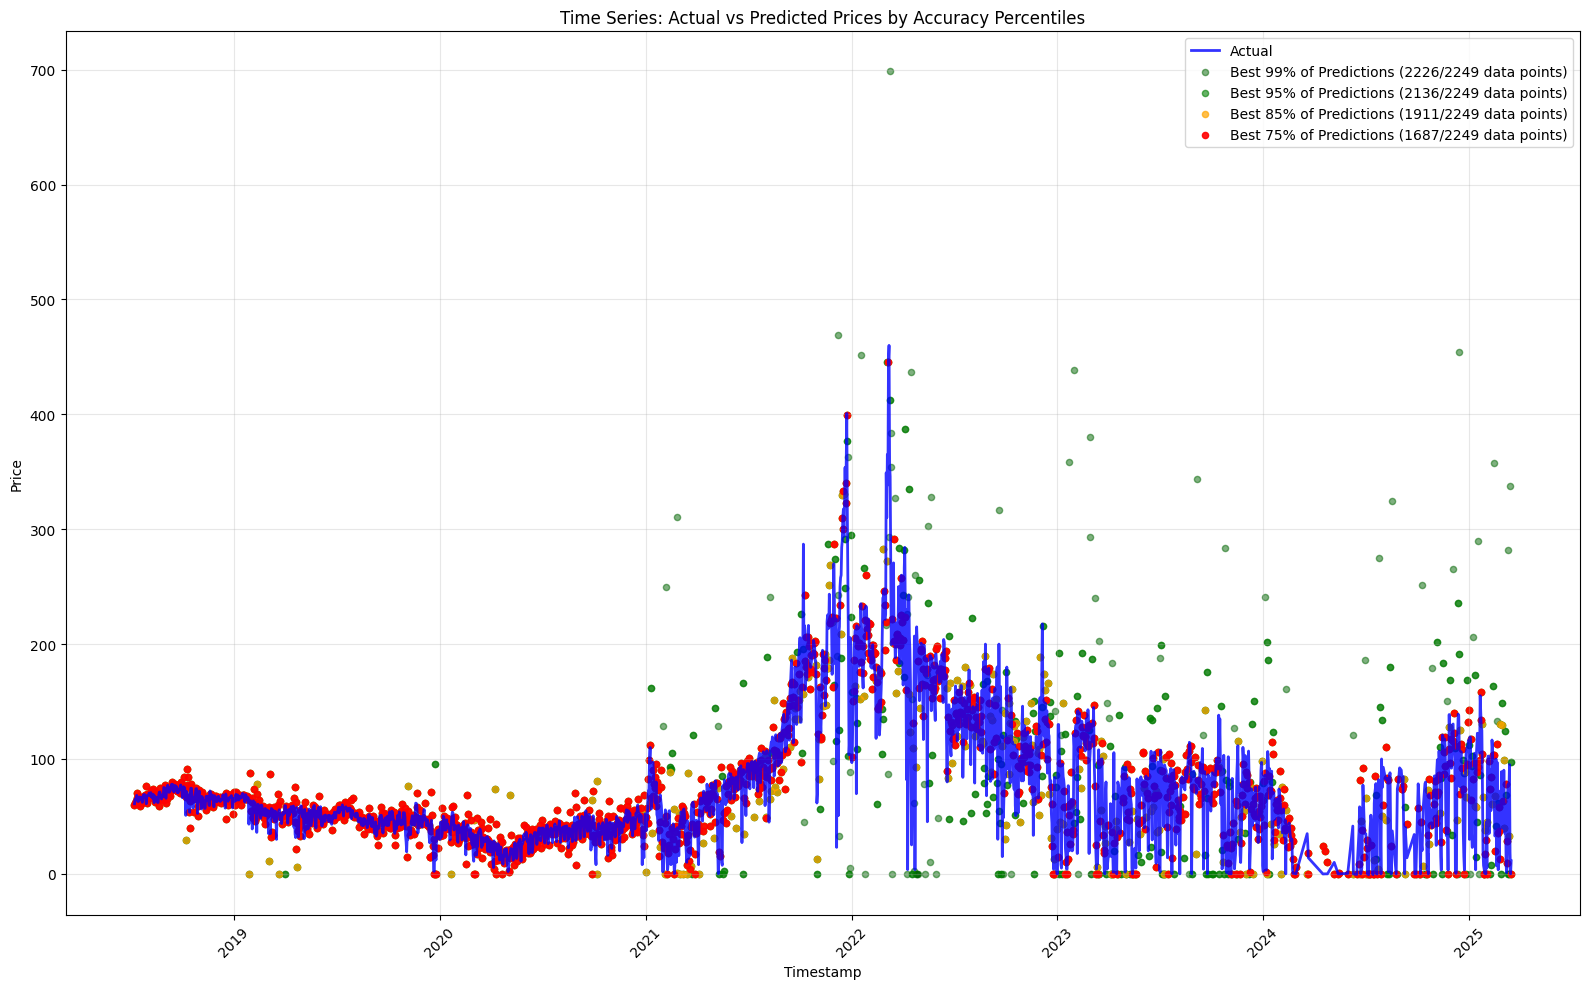

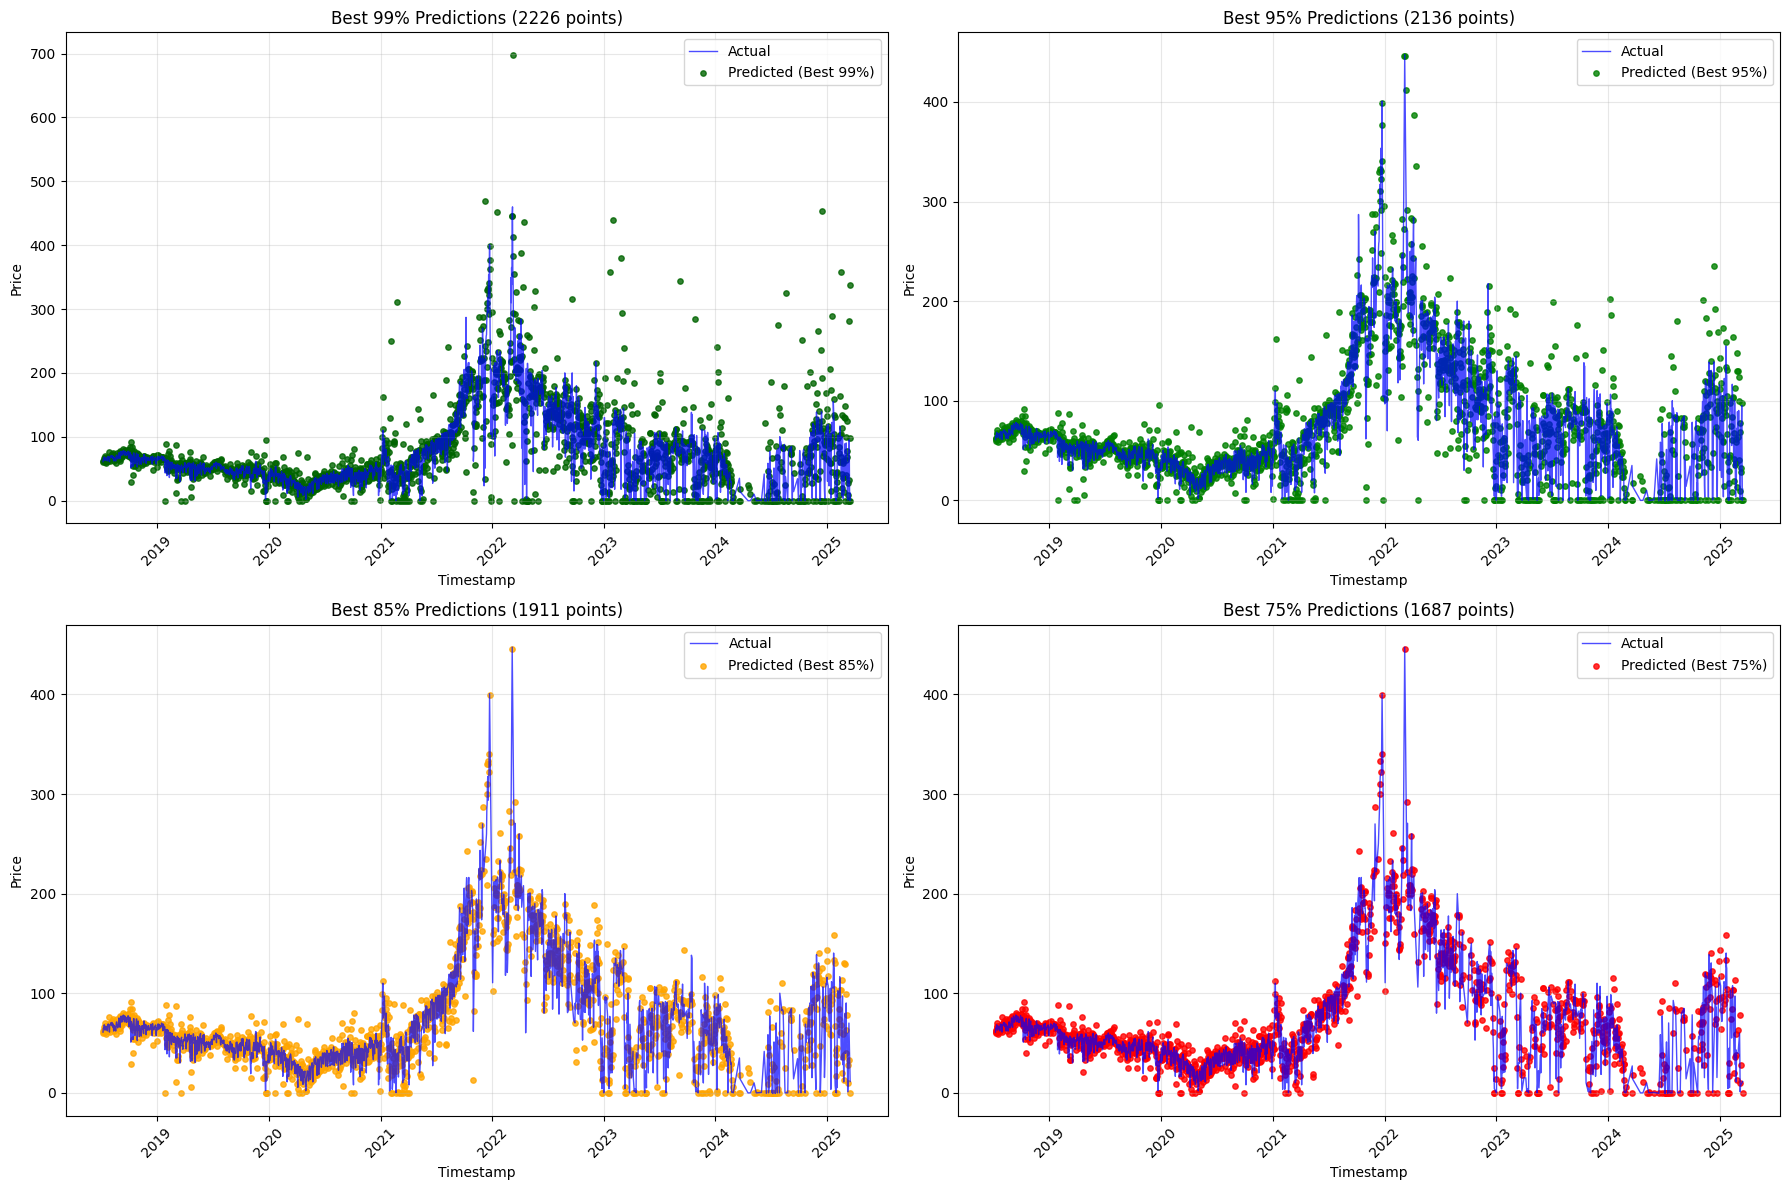

In [ ]:
import matplotlib.pyplot as plt

# Time series plots for different percentile accuracies
plt.figure(figsize=(16, 10))

# Calculate prediction errors for filtering
prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

percentiles = [99, 95, 85, 75]
colors = ['darkgreen', 'green', 'orange', 'red']
alphas = [0.5, 0.6, 0.7, 0.9]

# Plot actual values first
plt.plot(prediction_df['Timestamp'], prediction_df['Actual'], 
         label='Actual', color='blue', linewidth=2, alpha=0.8)

# Plot predictions for each percentile
for i, p in enumerate(percentiles):
    # Filter by best predictions (lowest errors)
    error_threshold = np.percentile(prediction_errors, p)
    best_indices = prediction_errors <= error_threshold
    
    filtered_timestamps = np.array(timestamps_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    
    if len(filtered_predictions) > 0:
        plt.scatter(filtered_timestamps, filtered_predictions, 
                   label=f'Best {p}% of Predictions ({len(filtered_predictions)}/{len(predictions_list)} data points)', 
                   color=colors[i], alpha=alphas[i], s=20)

plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Time Series: Actual vs Predicted Prices by Accuracy Percentiles')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Alternative: Separate subplots for each percentile
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, p in enumerate(percentiles):
    error_threshold = np.percentile(prediction_errors, p)
    best_indices = prediction_errors <= error_threshold
    
    filtered_timestamps = np.array(timestamps_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    filtered_actuals = np.array(actuals_list)[best_indices]
    
    if len(filtered_predictions) > 0:
        axes[i].plot(filtered_timestamps, filtered_actuals, 
                    label='Actual', color='blue', linewidth=1, alpha=0.7)
        axes[i].scatter(filtered_timestamps, filtered_predictions, 
                       label=f'Predicted (Best {p}%)', color=colors[i], alpha=0.8, s=15)
        
        axes[i].set_xlabel('Timestamp')
        axes[i].set_ylabel('Price')
        axes[i].set_title(f'Best {p}% Predictions ({len(filtered_predictions)} points)')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
# Save the figure
plt.savefig(f'regression_sw_{sliding_window}_pfw{lag_price_window}_regression_predictions_by_percentile.png', dpi=300)
plt.show()

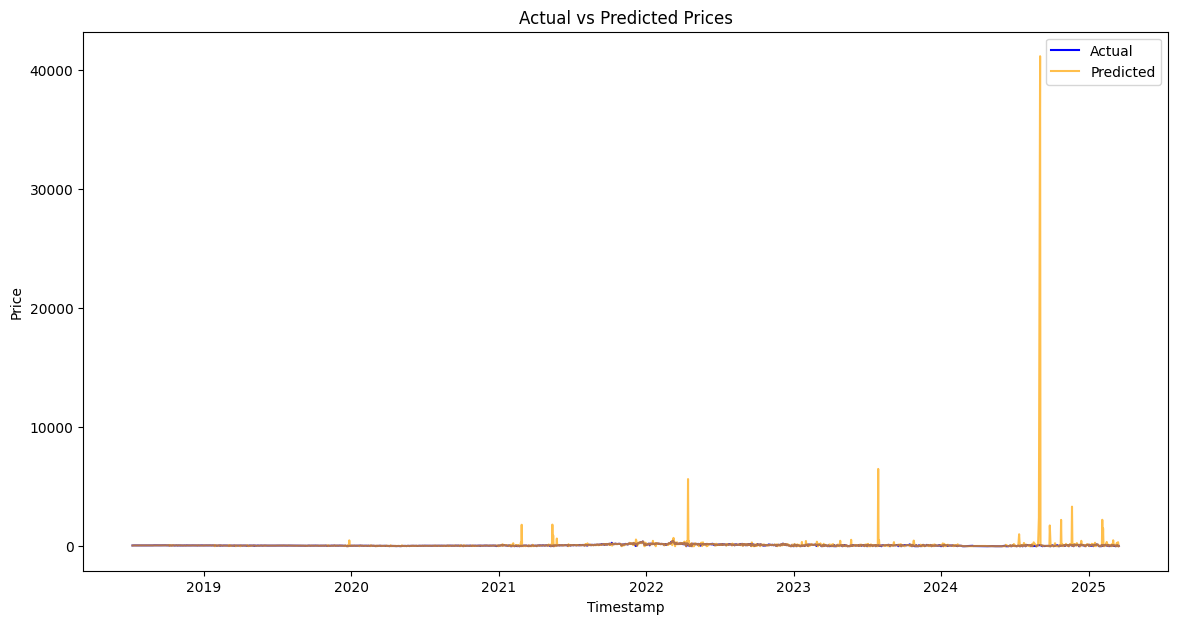

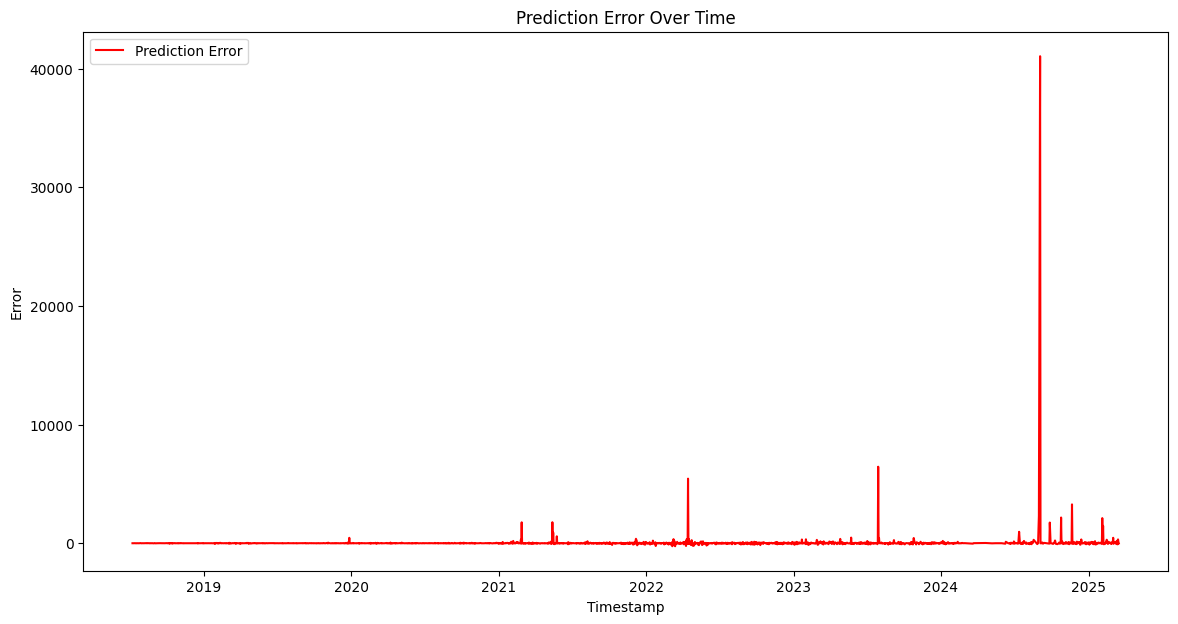

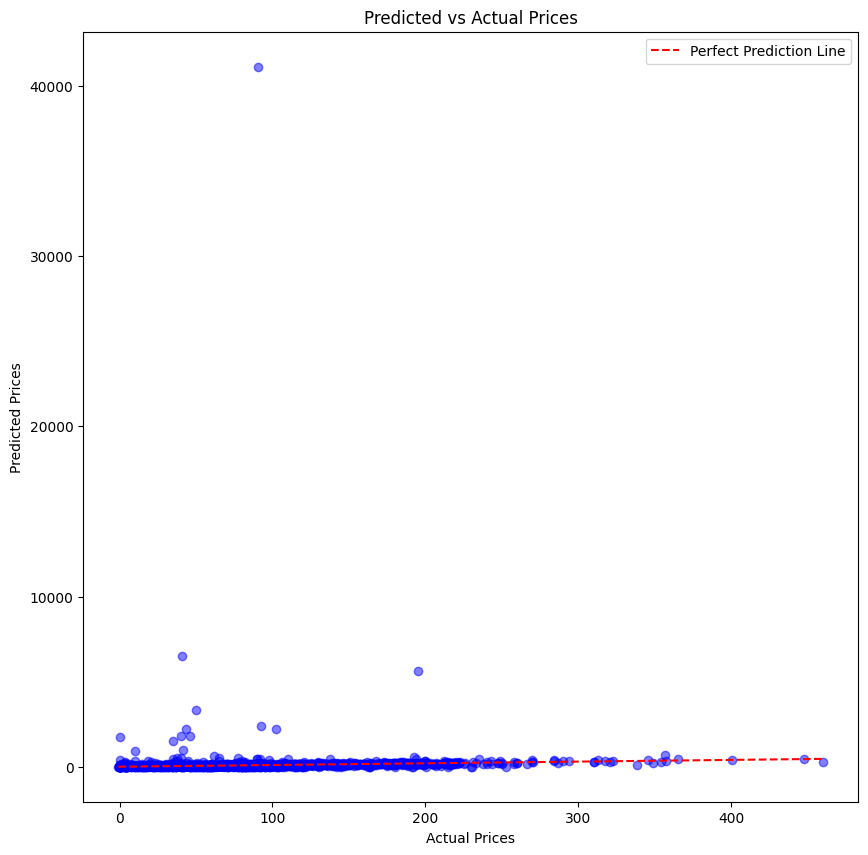

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(prediction_df['Timestamp'], prediction_df['Actual'], label='Actual', color='blue')
plt.plot(prediction_df['Timestamp'], prediction_df['Predicted'], label='Predicted', color='orange', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
# Save the figure
plt.savefig(f'regression_sw_{sliding_window}_pfw{lag_price_window}_regression_predictions.png', dpi=300)
plt.legend()

# Plot error metrics
plt.figure(figsize=(14, 7))
plt.plot(prediction_df['Timestamp'], prediction_df['Predicted'] - prediction_df['Actual'], label='Prediction Error', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Error')
plt.title('Prediction Error Over Time')
# save the figure
plt.savefig(f'regression_sw_{sliding_window}_pfw{lag_price_window}_regression_prediction_error.png', dpi=300)
plt.legend()

# Plot a scatter plot of predicted vs actual prices with the intercept line
plt.figure(figsize=(10, 10))
plt.scatter(prediction_df['Actual'], prediction_df['Predicted'], alpha=0.5, color='blue')
plt.plot([prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         [prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.legend()


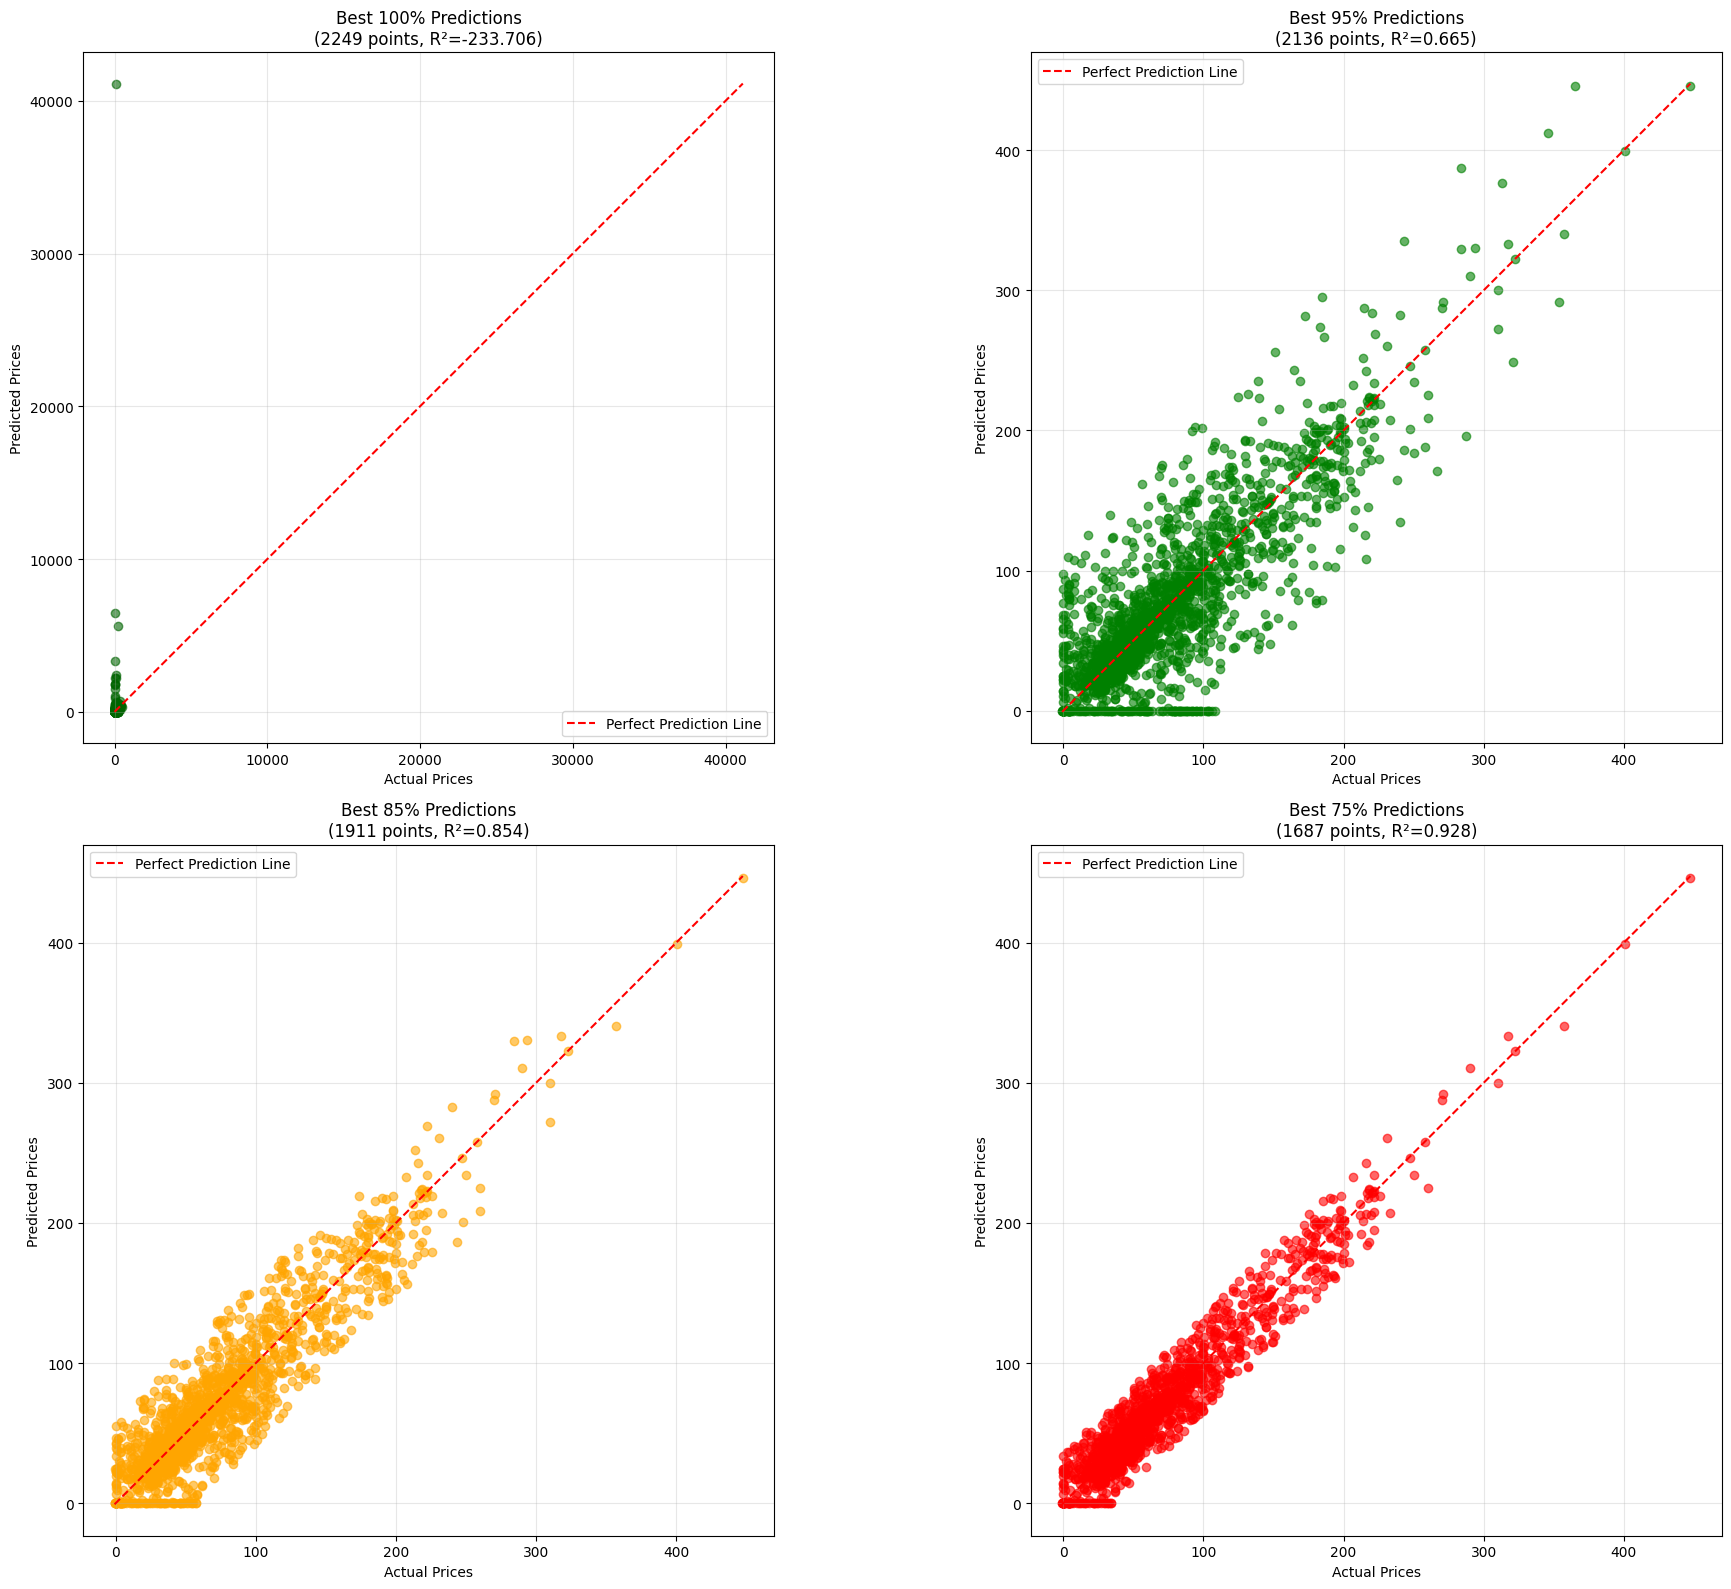

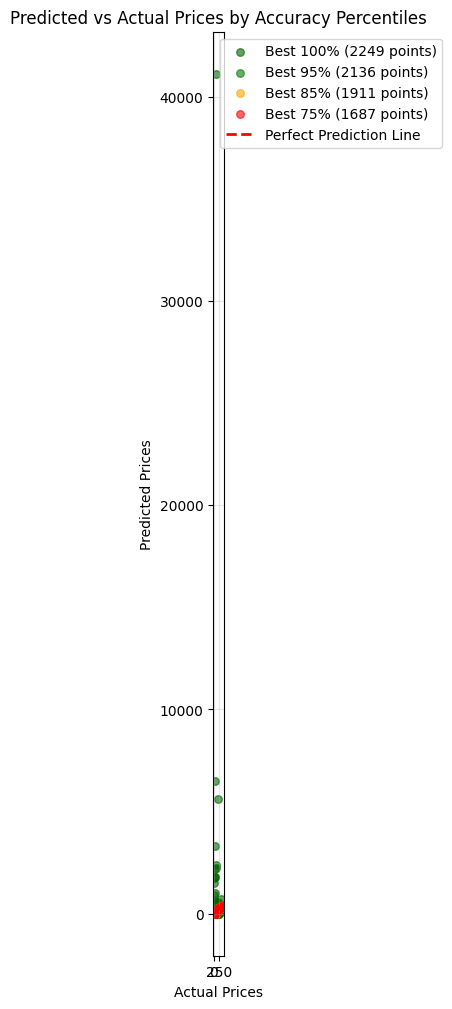

In [ ]:
# Create scatter plots for each percentile group
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

# Calculate prediction errors for filtering
prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

percentiles = [100, 95, 85, 75]
colors = ['darkgreen', 'green', 'orange', 'red']

for i, p in enumerate(percentiles):
    # Filter by best predictions (lowest errors)
    error_threshold = np.percentile(prediction_errors, p)
    best_indices = prediction_errors <= error_threshold
    
    filtered_actuals = np.array(actuals_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    
    if len(filtered_actuals) > 0:
        # Calculate metrics for this percentile
        mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
        mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
        r2_p = r2_score(filtered_actuals, filtered_predictions)
        
        # Create scatter plot
        axes[i].scatter(filtered_actuals, filtered_predictions, alpha=0.6, color=colors[i])
        
        # Perfect prediction line
        min_val = min(filtered_actuals.min(), filtered_predictions.min())
        max_val = max(filtered_actuals.max(), filtered_predictions.max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 
                    color='red', linestyle='--', label='Perfect Prediction Line')
        
        axes[i].set_xlabel('Actual Prices')
        axes[i].set_ylabel('Predicted Prices')
        axes[i].set_title(f'Best {p}% Predictions\n({len(filtered_actuals)} points, R²={r2_p:.3f})')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Make axes equal for better comparison
        axes[i].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Also create a combined scatter plot with all percentiles
plt.figure(figsize=(12, 12))

for i, p in enumerate(percentiles):
    error_threshold = np.percentile(prediction_errors, p)
    best_indices = prediction_errors <= error_threshold
    
    filtered_actuals = np.array(actuals_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    
    if len(filtered_actuals) > 0:
        plt.scatter(filtered_actuals, filtered_predictions, 
                   alpha=0.6, color=colors[i], 
                   label=f'Best {p}% ({len(filtered_actuals)} points)', s=30)

# Perfect prediction line
plt.plot([prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         [prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         color='red', linestyle='--', label='Perfect Prediction Line', linewidth=2)

plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices by Accuracy Percentiles')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Extra??


Metrics for best predictions by error percentiles:
Best 90% predictions - Count: 2024, MSE: 636.3721, MAE: 17.2667, R²: 0.7864
Best 80% predictions - Count: 1799, MSE: 274.8450, MAE: 12.0961, R²: 0.8992
Best 70% predictions - Count: 1574, MSE: 129.9845, MAE: 8.7455, R²: 0.9480
Best 60% predictions - Count: 1349, MSE: 65.9438, MAE: 6.4523, R²: 0.9714


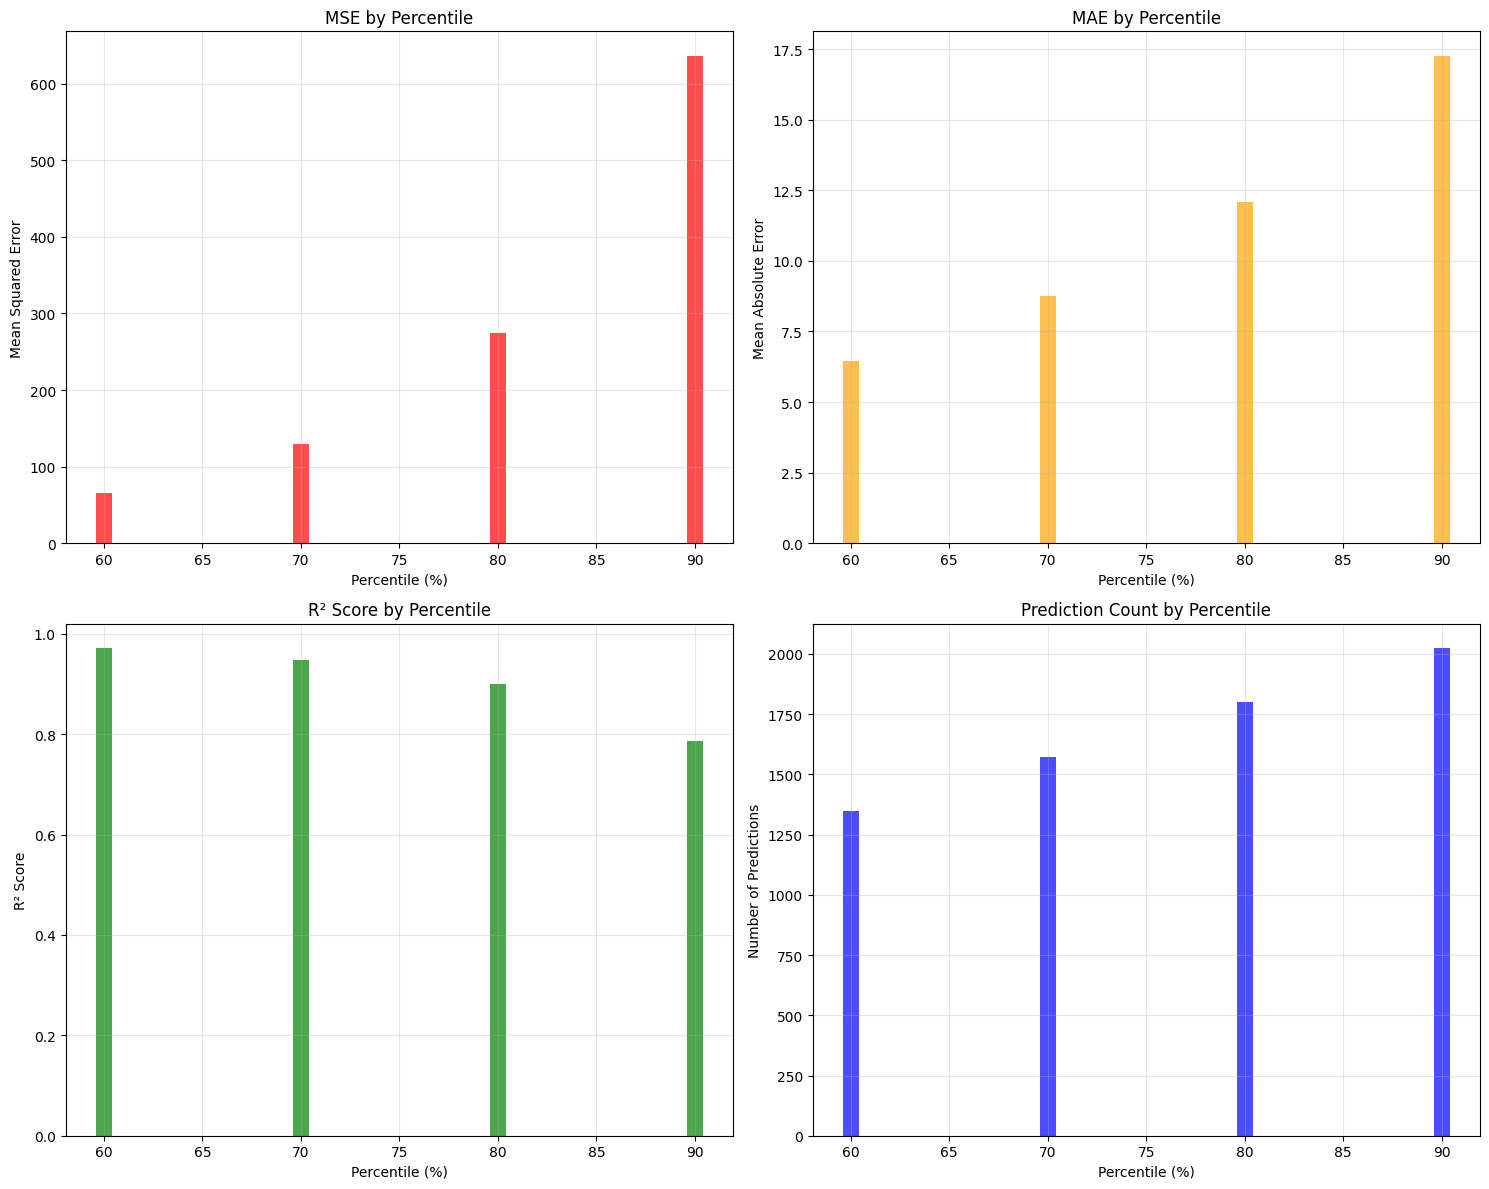

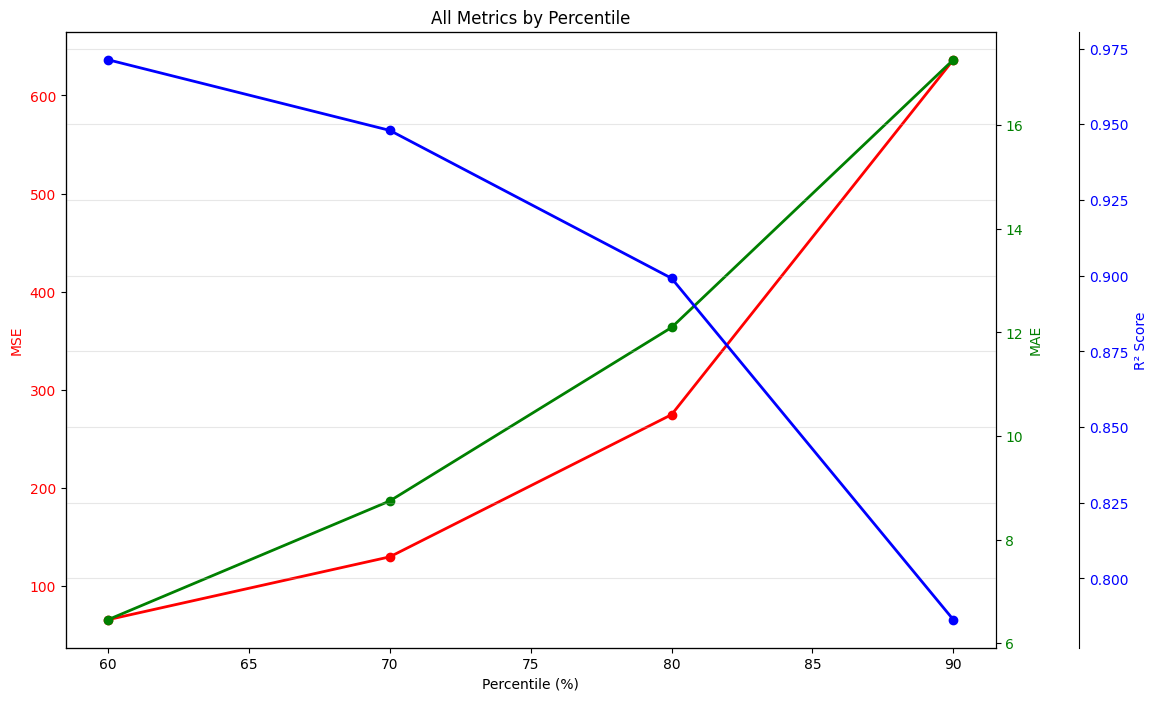

In [ ]:
import matplotlib.pyplot as plt


# Collect metrics for plotting
percentile_metrics = {'Percentile': [], 'MSE': [], 'MAE': [], 'R2': [], 'Count': []}

# Calculate prediction errors for filtering
prediction_errors = np.abs(np.array(predictions_list) - np.array(actuals_list))

percentiles = [90, 80, 70, 60]
print("\nMetrics for best predictions by error percentiles:")

for p in percentiles:
    # Filter by best predictions (lowest errors)
    error_threshold = np.percentile(prediction_errors, p)
    
    # Get indices of predictions with errors below threshold
    best_indices = prediction_errors <= error_threshold
    
    filtered_actuals = np.array(actuals_list)[best_indices]
    filtered_predictions = np.array(predictions_list)[best_indices]
    filtered_timestamps = np.array(timestamps_list)[best_indices]
    
    if len(filtered_actuals) > 0:
        mse_p = mean_squared_error(filtered_actuals, filtered_predictions)
        mae_p = mean_absolute_error(filtered_actuals, filtered_predictions)
        r2_p = r2_score(filtered_actuals, filtered_predictions)
        
        # Store metrics for plotting
        percentile_metrics['Percentile'].append(p)
        percentile_metrics['MSE'].append(mse_p)
        percentile_metrics['MAE'].append(mae_p)
        percentile_metrics['R2'].append(r2_p)
        percentile_metrics['Count'].append(len(filtered_actuals))
        
        # Save the filtered predictions and actuals in a DataFrame
        filtered_df = pd.DataFrame({
            'Timestamp': filtered_timestamps,
            'Actual': filtered_actuals,
            'Predicted': filtered_predictions,
            'Error': np.abs(filtered_predictions - filtered_actuals)
        })
        filtered_df.to_csv(f'best_predictions_percentile_{p}.csv', index=False)
        
        print(f"Best {p}% predictions - Count: {len(filtered_actuals)}, MSE: {mse_p:.4f}, MAE: {mae_p:.4f}, R²: {r2_p:.4f}")
    else:
        print(f"Best {p}% predictions - No data available")

# Create joint plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: MSE by Percentile
ax1.bar(percentile_metrics['Percentile'], percentile_metrics['MSE'], color='red', alpha=0.7)
ax1.set_xlabel('Percentile (%)')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('MSE by Percentile')
ax1.grid(True, alpha=0.3)

# Plot 2: MAE by Percentile
ax2.bar(percentile_metrics['Percentile'], percentile_metrics['MAE'], color='orange', alpha=0.7)
ax2.set_xlabel('Percentile (%)')
ax2.set_ylabel('Mean Absolute Error')
ax2.set_title('MAE by Percentile')
ax2.grid(True, alpha=0.3)

# Plot 3: R² by Percentile
ax3.bar(percentile_metrics['Percentile'], percentile_metrics['R2'], color='green', alpha=0.7)
ax3.set_xlabel('Percentile (%)')
ax3.set_ylabel('R² Score')
ax3.set_title('R² Score by Percentile')
ax3.grid(True, alpha=0.3)

# Plot 4: Count by Percentile
ax4.bar(percentile_metrics['Percentile'], percentile_metrics['Count'], color='blue', alpha=0.7)
ax4.set_xlabel('Percentile (%)')
ax4.set_ylabel('Number of Predictions')
ax4.set_title('Prediction Count by Percentile')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional combined line plot
plt.figure(figsize=(12, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax3 = ax1.twinx()

# Offset the third axis
ax3.spines['right'].set_position(('outward', 60))

line1 = ax1.plot(percentile_metrics['Percentile'], percentile_metrics['MSE'], 'ro-', label='MSE', linewidth=2)
line2 = ax2.plot(percentile_metrics['Percentile'], percentile_metrics['MAE'], 'go-', label='MAE', linewidth=2)
line3 = ax3.plot(percentile_metrics['Percentile'], percentile_metrics['R2'], 'bo-', label='R²', linewidth=2)

ax1.set_xlabel('Percentile (%)')
ax1.set_ylabel('MSE', color='red')
ax2.set_ylabel('MAE', color='green')
ax3.set_ylabel('R² Score', color='blue')

ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='green')
ax3.tick_params(axis='y', labelcolor='blue')

plt.title('All Metrics by Percentile')
plt.grid(True, alpha=0.3)
plt.show()